In [1]:
import pickle
import pandas as pd
import numpy as np

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")

import Plib.DataFarm.Finnhub as datafarm
import Plib.Utils.Tools as ut
%matplotlib inline

In [2]:
data = pd.read_csv("afterclass.csv", delimiter=';', decimal=',')
data.columns=['TIMESTAMP','BID_QTY_1','BID_PRICE_1','ASK_PRICE_1','ASK_QTY_1']

In [3]:
#data = pd.read_csv("practice.csv") 

In [4]:
#data= ut.fill_missing(data)
spread_limit=5
tick_size=0.0001
prob_up=0.55
prob_down=0.45

In [5]:
data['midp']=(data['BID_PRICE_1']+data['ASK_PRICE_1'])/2
data['spread']=(data['ASK_PRICE_1']-data['BID_PRICE_1'])/tick_size
data['return']=(data['midp']-data['midp'].shift(1)).shift(-1)

In [6]:
data['midp1']=data['midp'].shift(-1)
def ftrade(mp,mp1):
    retv=0
    if (mp1>mp):
        retv=1
    if (mp1<mp):
        retv=-1
    return retv
data['signal'] = data.apply(lambda x: ftrade(x['midp'], x['midp1']), axis=1)
del data['midp1']
data['signal']=data['signal'].replace(0,np.nan).ffill().bfill()
data.head(10)

TIMESTAMP  BID_QTY_1  BID_PRICE_1  ASK_PRICE_1  ASK_QTY_1      midp  \
0  1.500000e+12       25.0      0.87593      0.87691       25.0  0.876420   
1  1.500000e+12       25.0      0.87593      0.87680        1.0  0.876365   
2  1.500000e+12       25.0      0.87593      0.87660       50.0  0.876265   
3  1.500000e+12       25.0      0.87593      0.87660       49.9  0.876265   
4  1.500000e+12       25.0      0.87593      0.87661       50.0  0.876270   
5  1.500000e+12       25.0      0.87593      0.87660       50.0  0.876265   
6  1.500000e+12       50.0      0.87594      0.87660       50.0  0.876270   
7  1.500000e+12       50.0      0.87595      0.87660       50.0  0.876275   
8  1.500000e+12       50.0      0.87615      0.87660       50.0  0.876375   
9  1.500000e+12       50.0      0.87620      0.87660       50.0  0.876400   

   spread    return  signal  
0     9.8 -0.000055    -1.0  
1     8.7 -0.000100    -1.0  
2     6.7  0.000000    -1.0  
3     6.7  0.000005     1.0  
4     6.8 -0.000005    -1.0  
5     6.7  0.000005     1.0  
6     6.6  0.000005     1.0  
7     6.5  0.000100     1.0  
8     4.5  0.000025     1.0  
9     4.0  0.000015     1.0

In [7]:
#check for wrong data
data[data['signal']==0]

Empty DataFrame
Columns: [TIMESTAMP, BID_QTY_1, BID_PRICE_1, ASK_PRICE_1, ASK_QTY_1, midp, spread, return, signal]
Index: []

In [8]:
#A Markov model generates a sequence of states, with one possible realization being
#1,2,1,1,2,2,2,3,3,4
#We assume that the system was long-running before we started observing 
#the sequence of states, and as such the initial state was drawn as one realization of 
#some equilibrated distribution of states. 
#To know and understand how a system transitions between states, we now need a 
#transition matrix. The transition matrix describes the probability of transitioning ù
#from one state to another.

In [9]:
#Multiple states based on percentile
pb1,pb2=data.BID_QTY_1.quantile(0.25), data.BID_QTY_1.quantile(0.5)
pb3,pb4=data.BID_QTY_1.quantile(0.75), data.BID_QTY_1.quantile(1)
pa1,pa2=data.ASK_QTY_1.quantile(0.25), data.ASK_QTY_1.quantile(0.5)
pa3,pa4=data.ASK_QTY_1.quantile(0.75), data.ASK_QTY_1.quantile(1)

data['states_b']=data['BID_QTY_1'].apply(lambda x: 
        '1' if (x<=pb1) else (
        '2' if (x<=pb2 and x>pb1) else (
        '3' if (x<=pb3 and x>pb2) else (
        '4' if (x<=pb4 and x>pb3) else ('nhil')
        )))) 
data['states_a']=data['ASK_QTY_1'].apply(lambda x: 
        '1' if (x<=pa1) else (
        '2' if (x<=pa2 and x>pa1) else (
        '3' if (x<=pa3 and x>pa2) else (    
        '4' if (x<=pa4 and x>pa3) else ('nhil')
        )))) 

In [10]:
#Label the bid-ask states sequences by char and numerical
data['states_c'] = data['states_a'] + data['states_b']
data['prior_st_c']=data['states_c'].shift(-1)
#data['states_n'] = pd.factorize(data['states_b'] + data['states_a'])[0] + 1
#data['prior_st']=data['states_n'].shift(-1)
data.head()

TIMESTAMP  BID_QTY_1  BID_PRICE_1  ASK_PRICE_1  ASK_QTY_1      midp  \
0  1.500000e+12       25.0      0.87593      0.87691       25.0  0.876420   
1  1.500000e+12       25.0      0.87593      0.87680        1.0  0.876365   
2  1.500000e+12       25.0      0.87593      0.87660       50.0  0.876265   
3  1.500000e+12       25.0      0.87593      0.87660       49.9  0.876265   
4  1.500000e+12       25.0      0.87593      0.87661       50.0  0.876270   

   spread    return  signal states_b states_a states_c prior_st_c  
0     9.8 -0.000055    -1.0        1        1       11         11  
1     8.7 -0.000100    -1.0        1        1       11         21  
2     6.7  0.000000    -1.0        1        2       21         21  
3     6.7  0.000005     1.0        1        2       21         21  
4     6.8 -0.000005    -1.0        1        2       21         21

In [11]:
#check for wrong data
data[data['states_b']=='nhil']

Empty DataFrame
Columns: [TIMESTAMP, BID_QTY_1, BID_PRICE_1, ASK_PRICE_1, ASK_QTY_1, midp, spread, return, signal, states_b, states_a, states_c, prior_st_c]
Index: []

In [12]:
#check for wrong data
data[data['states_a']=='nhil']

Empty DataFrame
Columns: [TIMESTAMP, BID_QTY_1, BID_PRICE_1, ASK_PRICE_1, ASK_QTY_1, midp, spread, return, signal, states_b, states_a, states_c, prior_st_c]
Index: []

In [13]:
#Create frequency table for all states
states=data[['states_c','prior_st_c']].dropna()
states_mat=states.groupby(['states_c','prior_st_c']).size().unstack()
states_mat[np.isnan(states_mat)] = 0
states_mat

prior_st_c       11       12      13       14       21       22      23  \
states_c                                                                  
11          55281.0  15368.0  2310.0   3899.0   9562.0    127.0    79.0   
12          10663.0  15449.0  4749.0   6702.0    133.0   7696.0     5.0   
13           1590.0   2615.0   763.0   2846.0     87.0      4.0  1910.0   
14           5991.0   5784.0  1499.0  18035.0     24.0    126.0     5.0   
21           7743.0    111.0     1.0      5.0  14299.0  14152.0  5741.0   
22            206.0   6394.0    15.0    228.0  11374.0   7851.0  6599.0   
23            742.0      0.0  1509.0     26.0   5586.0   4557.0  1488.0   
24             45.0    403.0     2.0   5464.0   6975.0   7656.0  3961.0   
31           5197.0     18.0     1.0     46.0   7060.0    133.0  1035.0   
32            592.0   4565.0     2.0    434.0    529.0   7856.0    40.0   
33           1854.0      5.0  1897.0      3.0   1301.0      2.0  5098.0   
34              1.0    775.0    13.0   3741.0     44.0    642.0     6.0   
41           4143.0     13.0     1.0     46.0   2998.0    114.0   155.0   
42             46.0   2691.0     1.0      1.0     11.0   2107.0    13.0   
43              0.0     10.0  1175.0      0.0     10.0      2.0   679.0   
44              0.0     31.0    17.0   1775.0     14.0     84.0     2.0   

prior_st_c       24       31       32      33       34       41       42  \
states_c                                                                   
11             25.0   4380.0    432.0   272.0      2.0   2310.0     45.0   
12            117.0    116.0   6067.0    13.0    216.0      6.0   2247.0   
13             19.0    171.0      2.0  2958.0     14.0      5.0      1.0   
14           6346.0     20.0    429.0     0.0   3519.0     20.0      4.0   
21           4565.0  10738.0    451.0   223.0     68.0   1896.0      2.0   
22           8439.0    291.0   9595.0     5.0    250.0    143.0   1614.0   
23           6052.0    542.0     28.0  5272.0      3.0    498.0      0.0   
24          23582.0     16.0    602.0    17.0   8213.0     21.0    300.0   
31             41.0   9320.0  10264.0  6025.0   2863.0   6594.0    297.0   
32            590.0   8312.0   8901.0  7870.0   6128.0    116.0   5679.0   
33             62.0   5345.0   5458.0  3999.0   5676.0     56.0     36.0   
34           6918.0   5033.0   4929.0  4170.0  17954.0     15.0    272.0   
41             45.0   3973.0     62.0     0.0     11.0  16017.0   7867.0   
42            138.0    205.0   4214.0    26.0    195.0   6233.0  13196.0   
43              6.0    617.0      4.0  2752.0     41.0   3177.0   2568.0   
44           1385.0     26.0    260.0     1.0   2986.0   3184.0   3195.0   

prior_st_c      43       44  
states_c                     
11             0.0      2.0  
12            12.0     41.0  
13           937.0     33.0  
14             0.0   1449.0  
21             0.0     12.0  
22             3.0    102.0  
23           507.0      6.0  
24             1.0   1072.0  
31           150.0     61.0  
32             2.0     82.0  
33          2807.0      4.0  
34            29.0   3597.0  
41          2900.0   1946.0  
42          4470.0   3776.0  
43          5635.0   2656.0  
44          1879.0  12624.0

In [14]:
#Create frequency table for traded states
traded=data[['states_c','prior_st_c','signal']].dropna()
traded=traded[traded.signal==1]
del traded['signal']
traded_mat=traded.groupby(['states_c','prior_st_c']).size().unstack()
traded_mat[np.isnan(traded_mat)] = 0
traded_mat

prior_st_c       11      12      13      14      21      22      23      24  \
states_c                                                                      
11          27046.0  8264.0  1540.0   520.0  4607.0    86.0    21.0     1.0   
12           6383.0  6951.0  2747.0  3252.0    35.0  4619.0     5.0    37.0   
13           1264.0  1477.0   537.0  1571.0    18.0     1.0  1060.0    16.0   
14           5419.0  3687.0   730.0  7936.0    23.0    61.0     3.0  3421.0   
21           3232.0    70.0     0.0     2.0  7557.0  6888.0  3319.0   282.0   
22            120.0  3465.0    12.0   104.0  4997.0  3552.0  3626.0  2801.0   
23            701.0     0.0   833.0    20.0  4006.0  2616.0  1122.0  3093.0   
24             42.0   382.0     0.0  2684.0  5920.0  3785.0  1648.0  8656.0   
31           1360.0    10.0     1.0    15.0  3141.0    61.0     1.0     0.0   
32             25.0  1285.0     0.0    12.0    48.0  3900.0    27.0    36.0   
33            974.0     0.0   428.0     2.0   665.0     2.0  2649.0    39.0   
34              1.0   354.0     2.0   915.0    39.0   294.0     1.0  3125.0   
41             73.0     0.0     0.0     0.0   658.0    71.0     0.0     8.0   
42              0.0    25.0     0.0     0.0     1.0   720.0     0.0    14.0   
43              0.0     0.0     0.0     0.0     0.0     2.0   285.0     1.0   
44              0.0     0.0     0.0     6.0     1.0    58.0     0.0   438.0   

prior_st_c      31      32      33      34      41      42      43      44  
states_c                                                                    
11          2166.0   418.0   201.0     2.0  2223.0    44.0     0.0     0.0  
12             7.0  3652.0     7.0   132.0     6.0  2212.0    12.0    40.0  
13            83.0     2.0  1461.0    14.0     5.0     1.0   935.0    32.0  
14            12.0   393.0     0.0  1760.0    20.0     4.0     0.0  1434.0  
21          5947.0   423.0   171.0     3.0  1349.0     2.0     0.0    10.0  
22            90.0  5661.0     3.0   143.0   112.0  1277.0     1.0    50.0  
23           485.0     9.0  3070.0     3.0   498.0     0.0   459.0     3.0  
24             9.0   531.0     7.0  4190.0    10.0   293.0     1.0   843.0  
31          4489.0  5099.0  3288.0   159.0  3254.0   278.0   131.0     0.0  
32          4047.0  3629.0  4032.0  1909.0    20.0  3286.0     2.0    54.0  
33          3683.0  3151.0  2164.0  2702.0    47.0     7.0  1387.0     0.0  
34          4467.0  2346.0  1808.0  5631.0     5.0   230.0     4.0  1448.0  
41          2581.0    52.0     0.0     5.0  8790.0  4390.0  1563.0   164.0  
42            21.0  3016.0    22.0    40.0  3395.0  7741.0  2612.0  1468.0  
43           374.0     4.0  1718.0    30.0  2222.0  1523.0  3376.0  1463.0  
44            26.0   137.0     0.0  1719.0  2890.0  1832.0   889.0  5121.0

In [15]:
#Compute the probability matrix
#Looking at the transition matrix, we can note that a system staying in the state that it 
#enters into has larger probability mass to the diagonals. Conversely, a system transitioning 
#out of states that it enters into has larger probability mass to the off-diagonal.
#Note each column should have sum equals to one.
prob_mat=res=traded_mat/states_mat
prob_mat[np.isnan(prob_mat)] = 0
prob_mat

prior_st_c        11        12        13        14        21        22  \
states_c                                                                 
11          0.489246  0.537741  0.666667  0.133368  0.481803  0.677165   
12          0.598612  0.449932  0.578438  0.485228  0.263158  0.600182   
13          0.794969  0.564818  0.703801  0.552003  0.206897  0.250000   
14          0.904523  0.637448  0.486991  0.440033  0.958333  0.484127   
21          0.417409  0.630631  0.000000  0.400000  0.528498  0.486716   
22          0.582524  0.541914  0.800000  0.456140  0.439335  0.452426   
23          0.944744  0.000000  0.552021  0.769231  0.717150  0.574062   
24          0.933333  0.947891  0.000000  0.491215  0.848746  0.494383   
31          0.261689  0.555556  1.000000  0.326087  0.444901  0.458647   
32          0.042230  0.281490  0.000000  0.027650  0.090737  0.496436   
33          0.525351  0.000000  0.225619  0.666667  0.511145  1.000000   
34          1.000000  0.456774  0.153846  0.244587  0.886364  0.457944   
41          0.017620  0.000000  0.000000  0.000000  0.219480  0.622807   
42          0.000000  0.009290  0.000000  0.000000  0.090909  0.341718   
43          0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
44          0.000000  0.000000  0.000000  0.003380  0.071429  0.690476   

prior_st_c        23        24        31        32        33        34  \
states_c                                                                 
11          0.265823  0.040000  0.494521  0.967593  0.738971  1.000000   
12          1.000000  0.316239  0.060345  0.601945  0.538462  0.611111   
13          0.554974  0.842105  0.485380  1.000000  0.493915  1.000000   
14          0.600000  0.539080  0.600000  0.916084  0.000000  0.500142   
21          0.578122  0.061774  0.553828  0.937916  0.766816  0.044118   
22          0.549477  0.331911  0.309278  0.589995  0.600000  0.572000   
23          0.754032  0.511071  0.894834  0.321429  0.582322  1.000000   
24          0.416057  0.367060  0.562500  0.882060  0.411765  0.510167   
31          0.000966  0.000000  0.481652  0.496785  0.545726  0.055536   
32          0.675000  0.061017  0.486886  0.407707  0.512325  0.311521   
33          0.519616  0.629032  0.689055  0.577318  0.541135  0.476039   
34          0.166667  0.451720  0.887542  0.475959  0.433573  0.313635   
41          0.000000  0.177778  0.649635  0.838710  0.000000  0.454545   
42          0.000000  0.101449  0.102439  0.715710  0.846154  0.205128   
43          0.419735  0.166667  0.606159  1.000000  0.624273  0.731707   
44          0.000000  0.316245  1.000000  0.526923  0.000000  0.575687   

prior_st_c        41        42        43        44  
states_c                                            
11          0.962338  0.977778  0.000000  0.000000  
12          1.000000  0.984424  1.000000  0.975610  
13          1.000000  1.000000  0.997866  0.969697  
14          1.000000  1.000000  0.000000  0.989648  
21          0.711498  1.000000  0.000000  0.833333  
22          0.783217  0.791202  0.333333  0.490196  
23          1.000000  0.000000  0.905325  0.500000  
24          0.476190  0.976667  1.000000  0.786381  
31          0.493479  0.936027  0.873333  0.000000  
32          0.172414  0.578623  1.000000  0.658537  
33          0.839286  0.194444  0.494122  0.000000  
34          0.333333  0.845588  0.137931  0.402558  
41          0.548792  0.558027  0.538966  0.084275  
42          0.544682  0.586617  0.584340  0.388771  
43          0.699402  0.593069  0.599113  0.550828  
44          0.907663  0.573396  0.473124  0.405656

In [16]:
#Creating trading signal on probability
data=data.head(len(data)-1) #remove last row with nan
data['prob'] = prob_mat.lookup(data['states_c'], data['prior_st_c'])
data['mk_signal']=0
def ftrade(pr,spr):
    retv=0
    if (pr>prob_up) and (spr<=spread_limit):
        retv=1
    if (pr<prob_down) and (spr<=spread_limit):
        retv=-1
    return retv
data['mk_signal'] = data.apply(lambda x: ftrade(x['prob'], x['spread']), axis=1)
data.head(5)

/Users/rob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The 'lookup' method is deprecated and will beremoved in a future version.You can use DataFrame.melt and DataFrame.locas a substitute.
  This is separate from the ipykernel package so we can avoid doing imports until


TIMESTAMP  BID_QTY_1  BID_PRICE_1  ASK_PRICE_1  ASK_QTY_1      midp  \
0  1.500000e+12       25.0      0.87593      0.87691       25.0  0.876420   
1  1.500000e+12       25.0      0.87593      0.87680        1.0  0.876365   
2  1.500000e+12       25.0      0.87593      0.87660       50.0  0.876265   
3  1.500000e+12       25.0      0.87593      0.87660       49.9  0.876265   
4  1.500000e+12       25.0      0.87593      0.87661       50.0  0.876270   

   spread    return  signal states_b states_a states_c prior_st_c      prob  \
0     9.8 -0.000055    -1.0        1        1       11         11  0.489246   
1     8.7 -0.000100    -1.0        1        1       11         21  0.481803   
2     6.7  0.000000    -1.0        1        2       21         21  0.528498   
3     6.7  0.000005     1.0        1        2       21         21  0.528498   
4     6.8 -0.000005    -1.0        1        2       21         21  0.528498   

   mk_signal  
0          0  
1          0  
2          0  
3          0  
4          0

In [17]:
#check for not traded data
data[data['mk_signal']==0]

TIMESTAMP  BID_QTY_1  BID_PRICE_1  ASK_PRICE_1  ASK_QTY_1  \
0       1.500000e+12       25.0      0.87593      0.87691       25.0   
1       1.500000e+12       25.0      0.87593      0.87680        1.0   
2       1.500000e+12       25.0      0.87593      0.87660       50.0   
3       1.500000e+12       25.0      0.87593      0.87660       49.9   
4       1.500000e+12       25.0      0.87593      0.87661       50.0   
...              ...        ...          ...          ...        ...   
710743  1.500000e+12       25.0      0.87200      0.87235       25.0   
710744  1.500000e+12       25.0      0.87200      0.87234       25.0   
710745  1.500000e+12       25.0      0.87200      0.87235       25.0   
710746  1.500000e+12       25.0      0.87203      0.87237       25.0   
710747  1.500000e+12       25.0      0.87203      0.87240       25.0   

            midp  spread    return  signal states_b states_a states_c  \
0       0.876420     9.8 -0.000055    -1.0        1        1       11   
1       0.876365     8.7 -0.000100    -1.0        1        1       11   
2       0.876265     6.7  0.000000    -1.0        1        2       21   
3       0.876265     6.7  0.000005     1.0        1        2       21   
4       0.876270     6.8 -0.000005    -1.0        1        2       21   
...          ...     ...       ...     ...      ...      ...      ...   
710743  0.872175     3.5 -0.000005    -1.0        1        1       11   
710744  0.872170     3.4  0.000005     1.0        1        1       11   
710745  0.872175     3.5  0.000025     1.0        1        1       11   
710746  0.872200     3.4  0.000015     1.0        1        1       11   
710747  0.872215     3.7 -0.000020    -1.0        1        1       11   

       prior_st_c      prob  mk_signal  
0              11  0.489246          0  
1              21  0.481803          0  
2              21  0.528498          0  
3              21  0.528498          0  
4              21  0.528498          0  
...           ...       ...        ...  
710743         11  0.489246          0  
710744         11  0.489246          0  
710745         11  0.489246          0  
710746         11  0.489246          0  
710747         11  0.489246          0  

[300996 rows x 15 columns]

In [18]:
#Trade simulation - close the previous trade at each signal change (+1/-1)
data['mk_trades']= data['mk_signal'].replace(0,np.nan).ffill()
data['mk_trades']= data['mk_trades'].replace(np.nan,0)
data['trade_returns']=data['mk_trades']*data['return']

In [19]:
print("Total return: ",data['trade_returns'].sum())

Total return:  0.5545799999999693


In [20]:
print("Total ticks: ",(data['trade_returns'].sum())/tick_size)

Total ticks:  5545.799999999693


In [21]:
#Suppose the data above completely describe a full process (i.e., a whole trading day subsuming 
#all the relevant activities for such process). New instances of such process can be 
#described by states that cannot be not directly observed; however, they are related
#to the original process through a specific probability distribution.
#These are known as Hidden Markov Models (because new states are not directly observed) 
#and emissions are the new processes determined through the specific probability distribution.
#For instance, volatile days can be modeled on some data, whereas quite days on other.

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import gamma
from typing import List

def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    emissions = []
    for state in states:
        loc = mus[state]
        scale = sigmas[state]
        e = norm.rvs(loc=loc, scale=scale)
        emissions.append(e)
    return emissions

#rvs(mu, loc=0, size=1, random_state=None)
def poisson_emissions(states: List[int], lam: List[float]) -> List[int]:
    emissions = []
    for state in states:
        rate = lam[state]
        e = poisson.rvs(rate)
        emissions.append(e)
    return emissions

#rvs(a, loc=0, scale=1, size=1, random_state=None)
def gamma_emissions(states: List[int], lam: List[float]) -> List[int]:
    emissions = []
    for state in states:
        rate = lam[state]
        e = gamma.rvs(rate)
        emissions.append(e)
    return emissions

def ar_gaussian_heteroskedastic_emissions(states: List[int], k: float, sigmas: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=k * prev_loc, scale=sigmas[state])
        emissions.append(e)
        prev_loc = e
    return emissions

def ar_gaussian_homoskedastic_emissions(states: List[int], k: float, mus: List[float]) -> List[float]:
    emissions = []
    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=k * prev_loc + mus[state], scale=1)
        emissions.append(e)
        prev_loc = e
    return emissions

def gaussian_homoskedastic_emissions(states: List[int], mus: List[float]) -> List[float]:
    emissions = []

    prev_loc = 0
    for state in states:
        e = norm.rvs(loc=mus[state], scale=1)
        emissions.append(e)
        prev_loc = e
    return emissions

def plot_emissions(states, emissions):
    fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=1, sharex=True)

    axes[0].plot(states)
    axes[0].set_title("States")
    axes[1].plot(emissions)
    axes[1].set_title("Emissions")
    sns.despine();

In [23]:
#Extract first n transitions
ntrans=50000
states = list(map(int, (data.states_b.head(ntrans)).tolist()))

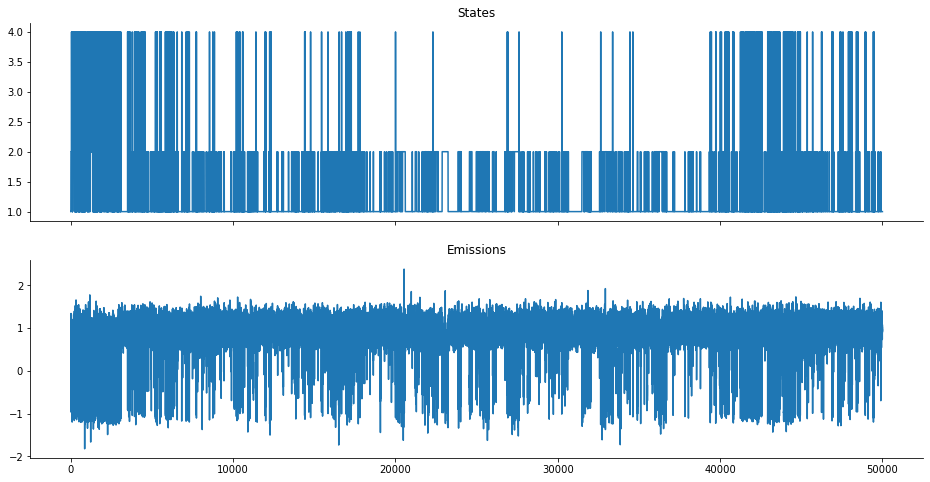

In [24]:
#Specify distributional parameters for each state - note: empty node at the beginning
gaussian_ems = gaussian_emissions(states, mus=[0,1, 0,0.5, -1], sigmas=[0,0.2, 0.5, 0.3,0.1])
plot_emissions(states, gaussian_ems)

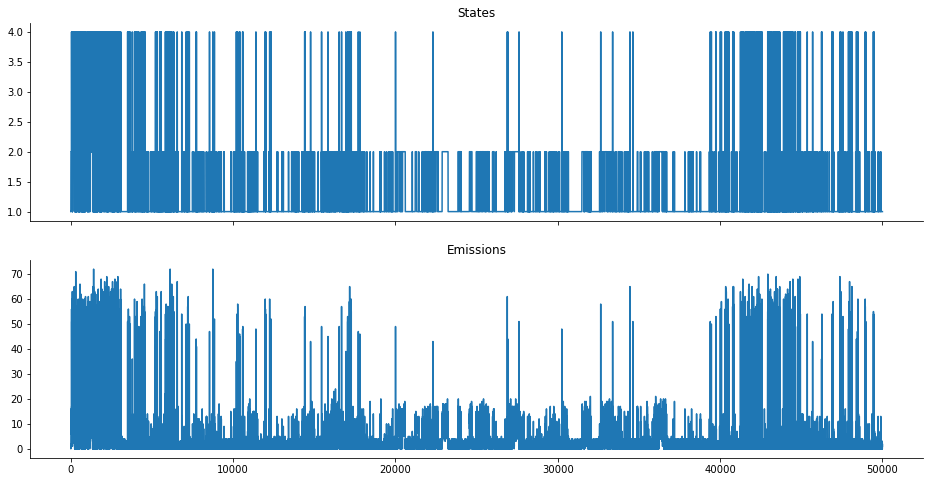

In [25]:
poisson_ems = poisson_emissions(states, lam=[0,1, 10,25, 50])
plot_emissions(states, poisson_ems)

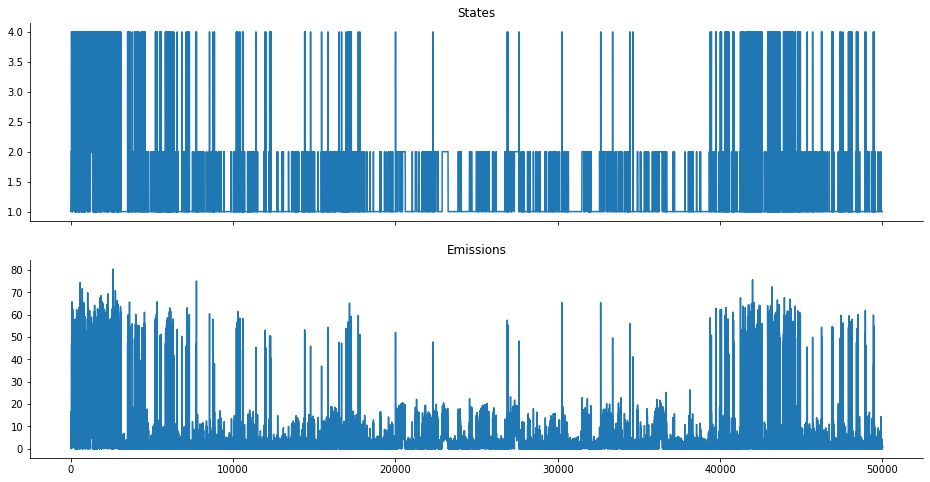

In [26]:
gamma_ems = gamma_emissions(states, lam=[0,1, 10,25, 50])
plot_emissions(states, gamma_ems)

In [27]:
#Autoregressive MM model that the emission value does not only depend on the current state, 
#but also on previous state(s) (for instance the motion of a person).
#Heteroskedastic Autoregressive Emissions have non-constant variance; a simple example has
#the location mu_t of the emission distribution at time t depending on y_{t-1}, 
#and the scale sigma depending only on the current state s_t. Substantially we are imposing
#that noise is the only thing that depends on state, while the location follows a random walk. 
#k is a multiplicative autoregressive coefficient that scales how the previous emission 
#affects the location \mu of the current emission. Also assume the initial location mu=0.
#Note the impact of k.

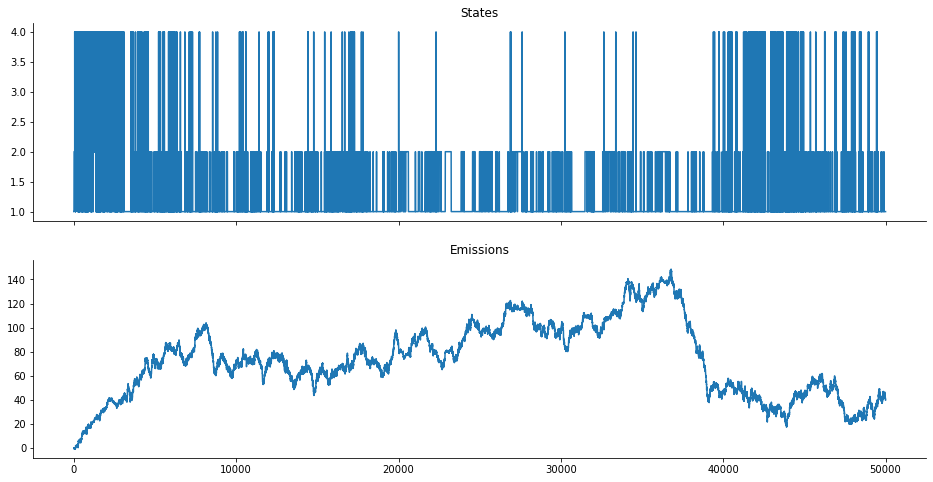

In [28]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=1, sigmas=[0,0.5, 0.1, 0.01,0.2])
plot_emissions(states, ar_het_ems)

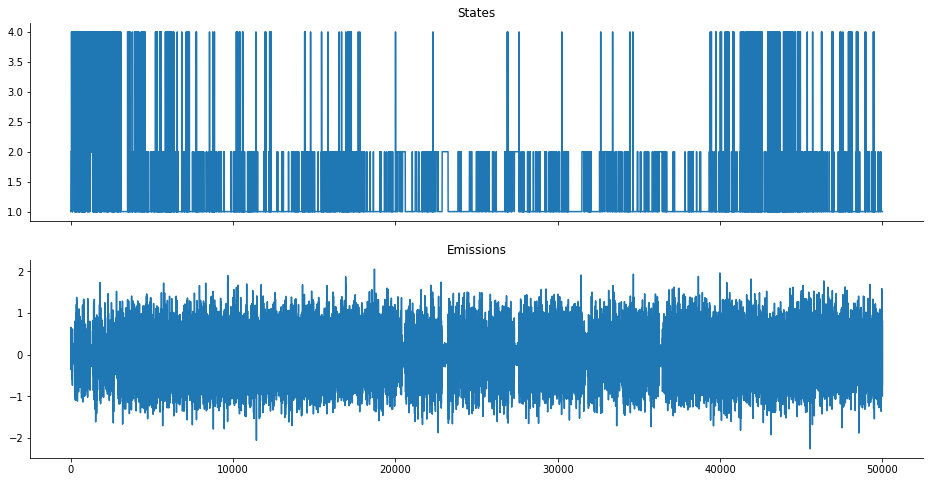

In [29]:
ar_het_ems = ar_gaussian_heteroskedastic_emissions(states, k=0, sigmas=[0,0.5, 0.1, 0.01,0.2])
plot_emissions(states, ar_het_ems)

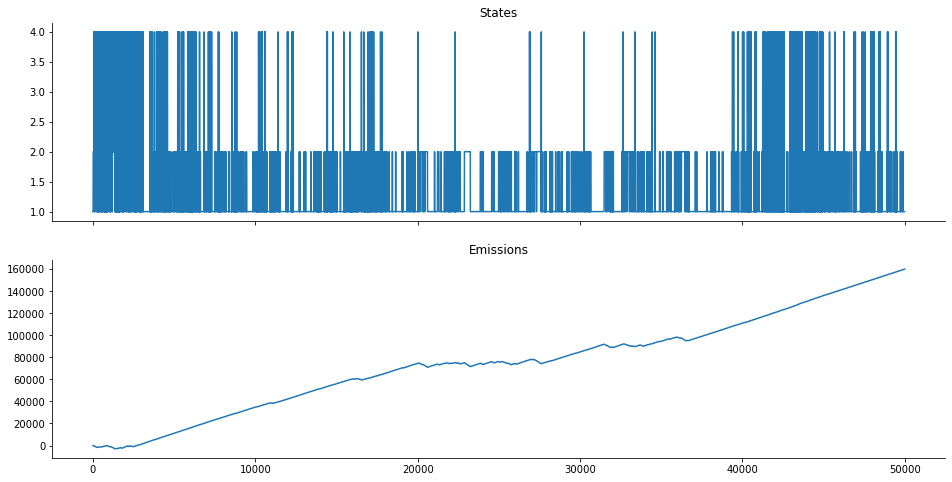

In [30]:
#Homoskedastic Autoregressive Emissions have constant variance
ar_hom_ems = ar_gaussian_homoskedastic_emissions(states, k=1, mus=[0,5,-10, 0, 10])
plot_emissions(states, ar_hom_ems)

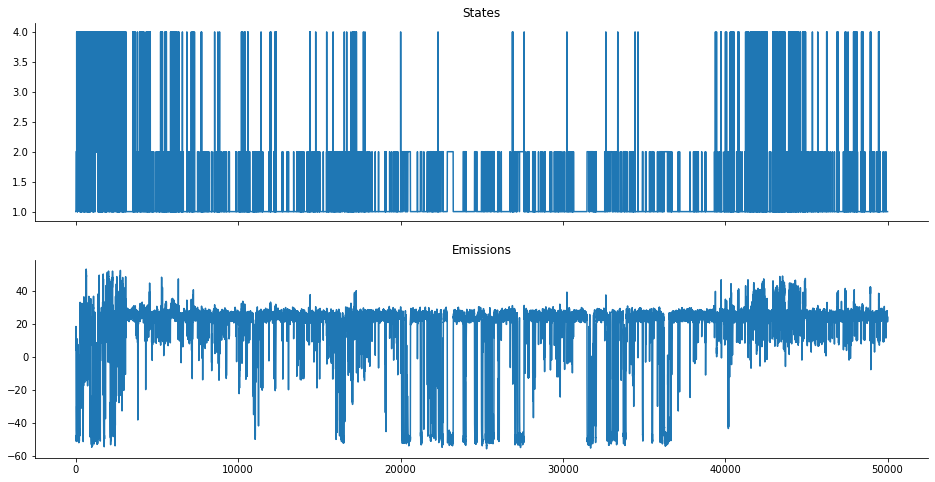

In [31]:
ar_hom_ems = ar_gaussian_homoskedastic_emissions(states, k=0.8, mus=[0,5,-10, 0, 10])
plot_emissions(states, ar_hom_ems)

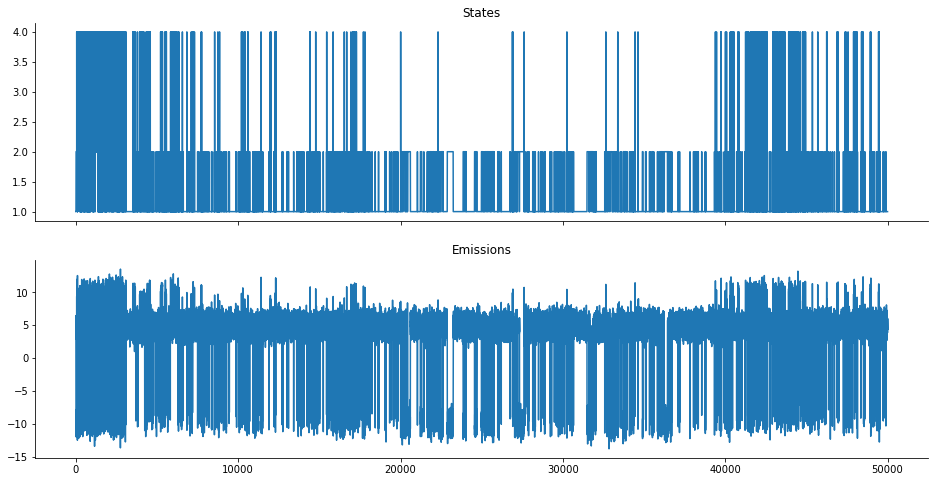

In [32]:
#Non-Autoregressive Homoskedastic Emissions have the mean mu depending only on the 
#hidden state at time t, and not on the previous hidden state or the previous emission value.
hom_ems = gaussian_homoskedastic_emissions(states, mus=[0,5,-10, 0, 10])
plot_emissions(states, hom_ems)
